In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
from transformers import ViTFeatureExtractor

model_ckpt = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_ckpt)

c:\Users\rkn\.virtualenvs\lab-work-bsKSxQpa\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\rkn\.virtualenvs\lab-work-bsKSxQpa\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [3]:
images_root = 'Affectnet/Manually_Annotated/Manually_Annotated_Images'

In [4]:
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image
import os


def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

class AffectNetDataset(Dataset):
    def __init__(self,
                 csvfile,
                 root,
                 mode='classification',
                 crop=False,
                 transform=None,
                 invalid_files=None):
        assert mode in ('valence', 'arousal', 'valence-arousal', 'classification')
        self.df = pd.read_csv(csvfile)
        self.root = root
        self.mode = mode
        self.crop = crop
        self.transform = transform
        self.invalid_files = invalid_files
        
        if self.invalid_files:
            self.df = self.df[~self.df['subDirectory_filePath'].isin(invalid_files)]
            self.df = self.df
        
        self.df = self.df[~((self.df['expression'] == 9) | (self.df['expression'] == 10))].reset_index(drop=True)
    
    def __getitem__(self, idx):
        try:
            img = pil_loader(os.path.join(self.root, self.df['subDirectory_filePath'][idx]))
        except KeyError:
            raise IndexError
        if self.crop:
            img = img.crop((self.df['face_x'][idx],
                            self.df['face_y'][idx],
                            self.df['face_x'][idx]+self.df['face_width'][idx],
                            self.df['face_y'][idx]+self.df['face_height'][idx],))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'classification':
            target = torch.tensor(self.df['expression'][idx])
        elif self.mode == 'valence':
            target = torch.tensor([self.df['valence'][idx]])
        elif self.mode == 'arousal':
            target = torch.tensor([self.df['arousal'][idx]])
        else:
            target = torch.tensor([self.df['valence'][idx],
                                   self.df['arousal'][idx]])
        return img.float(), target.float()
    
    def __len__(self):
        return len(self.df)

In [5]:
def collate_fn(examples):
    imgs, targets = zip(*examples)
    pixel_values = torch.stack(imgs)
    targets = torch.stack(targets)
    return {'pixel_values': pixel_values, 'labels': targets}

In [6]:
train_invalid_files = ['103/29a31ebf1567693f4644c8ba3476ca9a72ee07fe67a5860d98707a0a.jpg']
val_invalid_files = []

In [7]:
mode = 'valence-arousal'

In [8]:
from torchvision.transforms import (Compose,
                                    Normalize,
                                    Resize,
                                    ToTensor)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

transform = Compose([Resize(tuple(feature_extractor.size.values())),
                     ToTensor(),
                     normalize])

train_dataset = AffectNetDataset('Affectnet/training.csv',
                                 images_root,
                                 mode,
                                 crop=False,
                                 transform=transform,
                                 invalid_files=train_invalid_files)

val_dataset = AffectNetDataset('Affectnet/validation.csv',
                               images_root,
                               mode,
                               crop=False,
                               transform=transform,
                               invalid_files=val_invalid_files)

print('train:', len(train_dataset))
print('validation:', len(val_dataset))


train: 320739
validation: 4500


In [9]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('affectnet-contrastive',
                                                  num_labels=2,
                                                  problem_type='regression',
                                                  ignore_mismatched_sizes=True)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at affectnet-contrastive and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([128, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([128]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


カーネル密度推定によるMSEに重みづけ

In [10]:
import torch.nn.functional as F
import torch.nn as nn
from torch.nn.modules.loss import _Loss
from scipy.stats import gaussian_kde

class KDEWeightLoss(_Loss):
    def __init__(self, dataset, mode, bw_method=None, eps=1e-6, device=None):
        super(KDEWeightLoss, self).__init__()
        assert mode in ('valence', 'arousal', 'valence-arousal')
        self.mode = mode
        self.bw_method = bw_method
        self.eps = eps
        self.device = device
        self.kernel = self._calc_kernel(dataset.df)
    
    def forward(self, pred, target):
        loss = torch.mean(torch.dot(torch.tensor(1 / (self.kernel(target.cpu().T) + self.eps)).float().to(self.device),
                                    ((pred - target) ** 2).sum(1)))
        return loss
    
    def _calc_kernel(self, df):
        if self.mode == 'arousal':
            data = df[self.mode].to_numpy().T
        elif self.mode == 'valence':
            data = df[self.mode].to_numpy().T
        else:
            data = df[['valence', 'arousal']].to_numpy().T
        return gaussian_kde(data, bw_method=self.bw_method)

In [11]:
import wandb
from transformers import Trainer

class KDEWeightLossTrainer(Trainer):
    def __init__(self,
                 model = None,
                 args = None,
                 data_collator = None,
                 train_dataset = None,
                 eval_dataset = None,
                 tokenizer = None,
                 model_init = None,
                 compute_metrics = None,
                 callbacks = None,
                 optimizers = (None, None),
                 preprocess_logits_for_metrics = None):
        super().__init__(model, args, data_collator, train_dataset, eval_dataset, tokenizer, model_init, compute_metrics, callbacks, optimizers, preprocess_logits_for_metrics)
        self.loss_fct = KDEWeightLoss(dataset=train_dataset,
                                      mode=mode,
                                      bw_method=0.2,
                                      device=self.args.device).to(self.args.device)
        self.mse = nn.MSELoss()
    
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get('labels')
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss = self.loss_fct(logits, labels)
        mse = self.mse(logits, labels)
        rmse = torch.sqrt(mse)
        wandb.log({'train/mse': mse, 'train/rmse': rmse})
        return (loss, outputs) if return_outputs else loss

In [12]:
from transformers import TrainingArguments
import wandb

wandb.init(project='AffectNet-vit', name='KDE-contrastive-valaro')

args = TrainingArguments(
    f"affectnet-kdecnt-valaro",
    evaluation_strategy='steps',
    eval_steps=1000,
    save_strategy='steps',
    save_steps=1000,
    learning_rate=1e-6,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    num_train_epochs=30,
    weight_decay=1e-3,
    load_best_model_at_end=True,
    logging_dir='logs',
    remove_unused_columns=False,
    report_to='wandb'
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rkn. Use `wandb login --relogin` to force relogin


In [13]:
from sklearn.metrics import mean_squared_error
import numpy as np

def compute_metrics(eval_pred):
    preds, targets = eval_pred
    mse = mean_squared_error(targets, preds, squared=True) / 2
    rmse = np.sqrt(mse)
    return {'mse': mse, 'rmse': rmse}

In [14]:
from transformers import EarlyStoppingCallback

trainer = KDEWeightLossTrainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=4, early_stopping_threshold=0.005)]
)

In [15]:
trainer.train()

c:\Users\rkn\.virtualenvs\lab-work-bsKSxQpa\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 500/300720 [09:15<92:59:30,  1.12s/it]

{'loss': 37.7597, 'learning_rate': 9.98337323756318e-07, 'epoch': 0.05}


  0%|          | 1000/300720 [18:29<89:05:22,  1.07s/it]

{'loss': 29.9215, 'learning_rate': 9.966746475126364e-07, 'epoch': 0.1}


                                                        
  0%|          | 1000/300720 [20:14<89:05:22,  1.07s/it]

{'eval_loss': 27.559242248535156, 'eval_mse': 0.08728399872779846, 'eval_rmse': 0.29543865476236936, 'eval_runtime': 104.7925, 'eval_samples_per_second': 42.942, 'eval_steps_per_second': 2.691, 'epoch': 0.1}


  0%|          | 1500/300720 [29:25<88:55:15,  1.07s/it]  

{'loss': 29.4693, 'learning_rate': 9.950119712689545e-07, 'epoch': 0.15}


  1%|          | 2000/300720 [38:36<91:20:20,  1.10s/it] 

{'loss': 28.8017, 'learning_rate': 9.933492950252726e-07, 'epoch': 0.2}


                                                        
  1%|          | 2000/300720 [40:14<91:20:20,  1.10s/it]

{'eval_loss': 27.40435791015625, 'eval_mse': 0.09084326028823853, 'eval_rmse': 0.30140215707296875, 'eval_runtime': 98.2212, 'eval_samples_per_second': 45.815, 'eval_steps_per_second': 2.871, 'epoch': 0.2}


  1%|          | 2500/300720 [49:26<90:16:55,  1.09s/it]  

{'loss': 27.3222, 'learning_rate': 9.916866187815907e-07, 'epoch': 0.25}


  1%|          | 3000/300720 [58:34<91:10:05,  1.10s/it]

{'loss': 28.9065, 'learning_rate': 9.90023942537909e-07, 'epoch': 0.3}


                                                        
  1%|          | 3000/300720 [1:00:12<91:10:05,  1.10s/it]

{'eval_loss': 27.492273330688477, 'eval_mse': 0.09214739501476288, 'eval_rmse': 0.3035578940083141, 'eval_runtime': 97.6965, 'eval_samples_per_second': 46.061, 'eval_steps_per_second': 2.886, 'epoch': 0.3}


  1%|          | 3500/300720 [1:09:22<91:22:29,  1.11s/it]  

{'loss': 25.3598, 'learning_rate': 9.88361266294227e-07, 'epoch': 0.35}


  1%|▏         | 4000/300720 [1:18:32<90:24:43,  1.10s/it]

{'loss': 26.6712, 'learning_rate': 9.866985900505454e-07, 'epoch': 0.4}


                                                          
  1%|▏         | 4000/300720 [1:20:13<90:24:43,  1.10s/it]

{'eval_loss': 25.54353904724121, 'eval_mse': 0.08442460000514984, 'eval_rmse': 0.2905591161969451, 'eval_runtime': 101.2087, 'eval_samples_per_second': 44.463, 'eval_steps_per_second': 2.786, 'epoch': 0.4}


  1%|▏         | 4500/300720 [1:29:22<87:47:38,  1.07s/it]  

{'loss': 27.0126, 'learning_rate': 9.850359138068635e-07, 'epoch': 0.45}


  2%|▏         | 5000/300720 [1:38:29<88:48:51,  1.08s/it]

{'loss': 25.5321, 'learning_rate': 9.833732375631816e-07, 'epoch': 0.5}


                                                          
  2%|▏         | 5000/300720 [1:40:07<88:48:51,  1.08s/it]

{'eval_loss': 26.197221755981445, 'eval_mse': 0.0876946896314621, 'eval_rmse': 0.2961328918432772, 'eval_runtime': 97.4703, 'eval_samples_per_second': 46.168, 'eval_steps_per_second': 2.893, 'epoch': 0.5}


  2%|▏         | 5500/300720 [1:49:13<88:42:02,  1.08s/it]  

{'loss': 26.7328, 'learning_rate': 9.817105613194997e-07, 'epoch': 0.55}


  2%|▏         | 6000/300720 [1:58:18<88:16:44,  1.08s/it]

{'loss': 24.8258, 'learning_rate': 9.80047885075818e-07, 'epoch': 0.6}


                                                          
  2%|▏         | 6000/300720 [1:59:56<88:16:44,  1.08s/it]

{'eval_loss': 26.938669204711914, 'eval_mse': 0.0908934623003006, 'eval_rmse': 0.30148542634810827, 'eval_runtime': 97.2203, 'eval_samples_per_second': 46.287, 'eval_steps_per_second': 2.901, 'epoch': 0.6}


  2%|▏         | 6500/300720 [2:09:02<88:47:47,  1.09s/it]  

{'loss': 26.7176, 'learning_rate': 9.783852088321361e-07, 'epoch': 0.65}


  2%|▏         | 7000/300720 [2:18:08<90:48:01,  1.11s/it]

{'loss': 24.9955, 'learning_rate': 9.767225325884544e-07, 'epoch': 0.7}


                                                          
  2%|▏         | 7000/300720 [2:21:37<90:48:01,  1.11s/it]

{'eval_loss': 24.997657775878906, 'eval_mse': 0.08315934985876083, 'eval_rmse': 0.28837362892393753, 'eval_runtime': 209.3788, 'eval_samples_per_second': 21.492, 'eval_steps_per_second': 1.347, 'epoch': 0.7}


  2%|▏         | 7500/300720 [2:38:23<164:09:42,  2.02s/it] 

{'loss': 26.899, 'learning_rate': 9.750598563447725e-07, 'epoch': 0.75}


  3%|▎         | 8000/300720 [2:54:52<162:57:34,  2.00s/it]

{'loss': 24.2325, 'learning_rate': 9.733971801010906e-07, 'epoch': 0.8}


                                                           
  3%|▎         | 8000/300720 [2:58:43<162:57:34,  2.00s/it]

{'eval_loss': 25.66095542907715, 'eval_mse': 0.08562855422496796, 'eval_rmse': 0.2926235708636062, 'eval_runtime': 230.8038, 'eval_samples_per_second': 19.497, 'eval_steps_per_second': 1.222, 'epoch': 0.8}


  3%|▎         | 8500/300720 [3:15:31<162:36:09,  2.00s/it] 

{'loss': 25.2759, 'learning_rate': 9.71734503857409e-07, 'epoch': 0.85}


  3%|▎         | 9000/300720 [3:31:52<133:00:38,  1.64s/it]

{'loss': 24.2228, 'learning_rate': 9.70071827613727e-07, 'epoch': 0.9}


                                                           
  3%|▎         | 9000/300720 [3:35:26<133:00:38,  1.64s/it]

{'eval_loss': 25.0563907623291, 'eval_mse': 0.08317624032497406, 'eval_rmse': 0.2884029131700546, 'eval_runtime': 213.1364, 'eval_samples_per_second': 21.113, 'eval_steps_per_second': 1.323, 'epoch': 0.9}


  3%|▎         | 9500/300720 [3:46:43<165:39:54,  2.05s/it] 

{'loss': 25.9952, 'learning_rate': 9.684091513700452e-07, 'epoch': 0.95}


  3%|▎         | 10000/300720 [3:57:30<88:59:17,  1.10s/it]

{'loss': 24.9557, 'learning_rate': 9.667464751263633e-07, 'epoch': 1.0}


                                                           
  3%|▎         | 10000/300720 [3:59:53<88:59:17,  1.10s/it]

{'eval_loss': 25.68758773803711, 'eval_mse': 0.08572172373533249, 'eval_rmse': 0.2927827244482374, 'eval_runtime': 142.8382, 'eval_samples_per_second': 31.504, 'eval_steps_per_second': 1.974, 'epoch': 1.0}


  3%|▎         | 10500/300720 [4:16:41<157:33:23,  1.95s/it] 

{'loss': 26.2959, 'learning_rate': 9.650837988826816e-07, 'epoch': 1.05}


  4%|▎         | 11000/300720 [4:33:21<161:01:43,  2.00s/it]

{'loss': 24.31, 'learning_rate': 9.634211226389997e-07, 'epoch': 1.1}


                                                            
  4%|▎         | 11000/300720 [4:37:11<161:01:43,  2.00s/it]

{'eval_loss': 26.269851684570312, 'eval_mse': 0.08879151195287704, 'eval_rmse': 0.29797904616411713, 'eval_runtime': 230.7688, 'eval_samples_per_second': 19.5, 'eval_steps_per_second': 1.222, 'epoch': 1.1}


  4%|▎         | 11000/300720 [4:37:13<121:41:38,  1.51s/it]

{'train_runtime': 16633.585, 'train_samples_per_second': 578.478, 'train_steps_per_second': 18.079, 'train_loss': 26.918874200994317, 'epoch': 1.1}


TrainOutput(global_step=11000, training_loss=26.918874200994317, metrics={'train_runtime': 16633.585, 'train_samples_per_second': 578.478, 'train_steps_per_second': 18.079, 'train_loss': 26.918874200994317, 'epoch': 1.1})

In [16]:
trainer.save_model()
trainer.save_state()
wandb.finish()

eval/loss,███▂▄▆▁▃▁▃▄
eval/mse,▄▇█▂▅▇▁▃▁▃▅
eval/rmse,▄▇█▂▅▇▁▃▁▃▅
eval/runtime,▁▁▁▁▁▁▇█▇▃█
eval/samples_per_second,▇█████▂▁▁▄▁
eval/steps_per_second,▇█████▂▁▁▄▁
train/epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
train/learning_rate,██▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▁▁
train/loss,█▄▄▃▃▃▂▂▂▂▂▁▂▁▂▁▂▁▂▁▂▁
train/mse,▆▃▃▇▂▂▂▃▂▃▇▂▄▂▄▂▃▆▂▂▃▁▂▃▆█▃▅▅▂▂▃▆▂▂▄▂▂▃▅


In [23]:
from tqdm import tqdm

def CLE_tokens(model, tokenizer, dataset, device):
    tokens = []
    labels = []
    for img, label in tqdm(dataset):
        # feature = tokenizer(img, return_tensors='pt').pixel_values.to(device)
        with torch.no_grad():
            token = model(img.unsqueeze(0).to(device), output_hidden_states=True).hidden_states[-1][0,0,:]
        tokens.append(token.cpu())
        labels.append(label)
    return torch.stack(tokens).squeeze(), torch.stack(labels)

In [31]:
from umap import UMAP
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm

def plot_tokens(tokens, targets, n_neighbors):
    fig = plt.figure(figsize=(15, 15))
    plt.subplots_adjust(wspace=0.4, hspace=0.6)
    for i, category in enumerate(['valence', 'arousal']):
        umap = UMAP(n_neighbors=n_neighbors)
        xy = np.array(umap.fit_transform(tokens.numpy()))
        x = xy[:, 0]
        y = xy[:, 1]
        z = targets[:, i]
        ax = fig.add_subplot(1, 2, i+1)
        ax.set_aspect('equal', adjustable='box')
        ax.set_xlabel('feature-1')
        ax.set_ylabel('feature-2')
        ax.set_title(category)
        mp = ax.scatter(x, y,
                        alpha=0.5,
                        c=z,
                        cmap=cm.jet,
                        vmin=-1,
                        vmax=1,
                        s=3)
        fig.colorbar(mp, ax=ax, shrink=0.335)
    plt.show()
    return fig


In [25]:
tokens, targets = CLE_tokens(model,
                             feature_extractor,
                             val_dataset,
                             device)
print(tokens.shape, targets.shape)

100%|██████████| 4500/4500 [01:07<00:00, 66.95it/s]

torch.Size([4500, 768]) torch.Size([4500, 2])


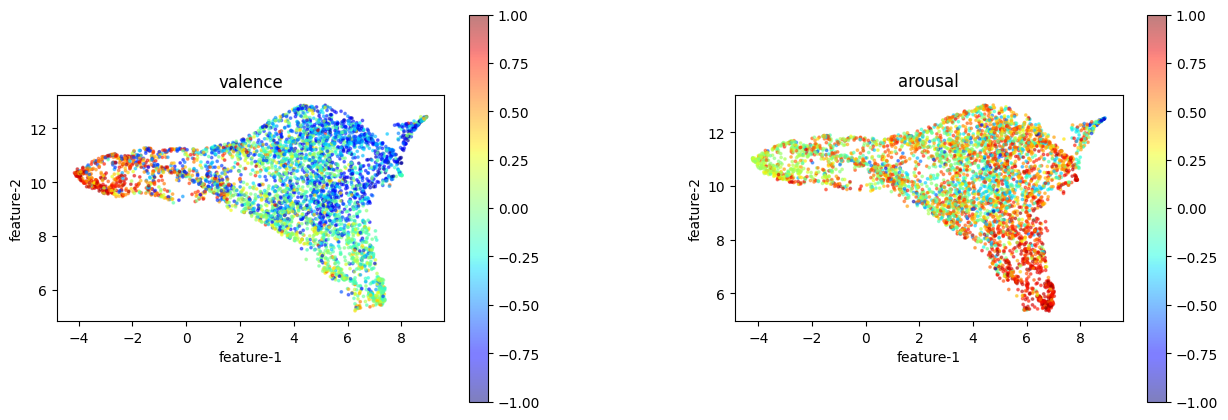

In [32]:
finetuned_fig = plot_tokens(tokens, targets, 30)